## Introduction 

Airbnb has become a popular choice for travelers seeking unique accommodations and for hosts looking to monetize their properties. Understanding the dynamics of the Airbnb market in Seattle is crucial for both hosts and guests to optimize their experiences and for Airbnb as a platform to enhance its offerings.

This project follows the CRISP-DM framework as outlined in the Udacity tutorials. The following steps are involved:
- Business Understanding
- Data Understanding
- Data Preparation
- Modeling
- Evaluation
- Deployment

## Business Understanding 

This analysis aims to delve into key aspects of the Airbnb market in Seattle by addressing three fundamental questions. 

- What are the busiest times of the year in Seattle for Airbnb bookings?
- What is the impact of property type and room type on the pricing of Airbnb in Seattle?
- Can we predict the likelihood of a positive review based on listing attributes?

To answers these questions we will utilized data from the listings and calendar databases.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load listings and calendar datasets
listings_df = pd.read_csv("listings_seattle.csv")
calendar_df = pd.read_csv("calendar_seattle.csv")

In [3]:
#Function for Plotting
def plot_data(data, x_column, y_column, title, plot_type='line', **kwargs):
    
    if plot_type == 'line':
        plt.plot(data[x_column], data[y_column], marker='o', **kwargs)
    elif plot_type == 'bar':
        sns.barplot(x=x_column, y=y_column, data=data, **kwargs)
    elif plot_type == 'box':
        sns.boxplot(x=x_column, y=y_column, data=data, **kwargs)
    
    plt.title(title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.show()

## Question 1: What are the busiest times of the year in Seattle for Airbnb bookings?

## Data Understanding

To answer this question, we will use calendar dataset as it contains availability by date. We need to identify the periods of availability and to determine which dates are booked and which are available.

In [4]:
# Display the first few rows of the dataframe
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [5]:
# Check for missing values
calendar_df.isnull().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [6]:
# Check the type of the columns
calendar_df.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

## Data Preparation

First we have convert the 'price' column from a string format to a numeric format, which is more suitable for mathematical operations and analysis.

Most of 'price' values are nulls. Here we have fill the missing values with the median price which is a common strategy to maintain the distribution of prices in the dataset while handling missing data.

Also, we have maps 't' to 1 and 'f' to 0 using the map() method, effectively converting this categorical data into numerical format (1 for available, 0 for not available).

In [7]:
# Data Cleaning and Preprocessing
# Convert 'date' column to datetime format
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

# Convert 'price' column to numeric after removing the $ sign and commas
calendar_df['price'] = calendar_df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Fill missing values in 'price' column with the median price
median_price = calendar_df['price'].median()
calendar_df['price'].fillna(median_price, inplace=True)

# Convert 'available' column to numeric format
calendar_df['available'] = calendar_df['available'].map({'t': 1, 'f': 0})

# Extract month from the 'date' column
calendar_df['month'] = calendar_df['date'].dt.month

# Calculate the average occupancy rate and pricing for each month
monthly_stats = calendar_df.groupby('month').agg({'available': 'mean', 'price': 'mean'}).reset_index()

In [8]:
# Check for missing values after filling
calendar_df.isnull().sum()

listing_id    0
date          0
available     0
price         0
month         0
dtype: int64

In [9]:
# Display the monthly statistics
monthly_stats

,month,available,price
0,1,0.566937,116.887332
1,2,0.662208,119.127761
2,3,0.709187,122.931623
3,4,0.663847,126.324411
4,5,0.675670,129.633747
5,6,0.674384,134.945687
6,7,0.627097,136.024232
7,8,0.645051,135.870647
8,9,0.674402,132.102279
9,10,0.696514,128.524637


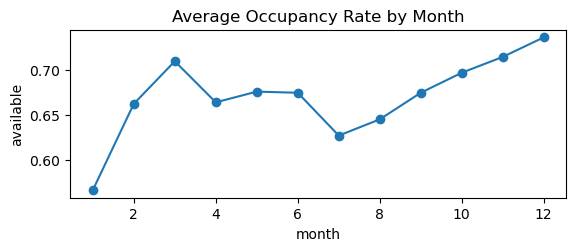

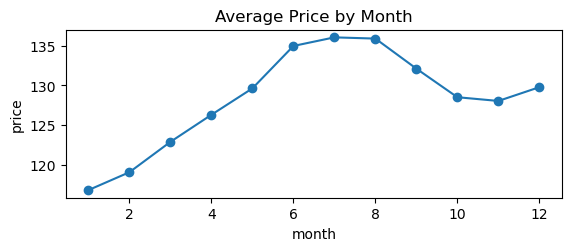

In [10]:
# Plot average occupancy rate
plt.subplot(2, 1, 1)
plot_data(monthly_stats, 'month', 'available', 'Average Occupancy Rate by Month', plot_type='line')
# Plot average price
plt.subplot(2, 1, 2)
plot_data(monthly_stats, 'month', 'price', 'Average Price by Month', plot_type='line')

**Figure 1 above shows that the busiest time of the year in Seattle for Airbnb bookings are in March and December.**

**Figure 2 above shows additional information indicating an inverse relationship between occupancy and pricing, so when the occupancy decrease the price will increase.** 

## Question 2: What is the impact of property type and room type on the pricing of Airbnb in Seattle?

## Data Understanding

To tackle this question, we must collect data on property type, room type, and pricing from the Seattle Airbnb listings dataset. Then, we'll analyze the data to observe the impact of pricing differences.

In [11]:
# Display the first few rows of the dataframe
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [12]:
# Check data types of all columns
listings_df.dtypes

id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
                                     ...   
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
calculated_host_listings_count        int64
reviews_per_month                   float64
Length: 92, dtype: object

## Data Preparation

Initially, we'll discard any columns that won't be utilized, shifting our attention to the key columns: property type, room type, and pricing.

Since there's only one missing value in the "property type" column, and the dataset is large, we'll remove the corresponding row as it won't significantly impact our analysis.

In [13]:
# Data Cleaning and Preprocessing
# Drop columns with too many missing values or not relevant to price analysis
listings_df1 = listings_df.drop(columns=['id', 'listing_url','host_since', 'scrape_id', 'last_scraped', 'name', 
                                        'summary', 'space', 'description', 'experiences_offered', 
                                        'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 
                                        'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 
                                        'host_url', 'host_name', 'host_location', 'host_about', 
                                        'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 
                                        'host_total_listings_count', 'host_verifications', 
                                        'host_has_profile_pic', 'host_identity_verified', 'street', 
                                        'neighbourhood', 'neighbourhood_cleansed', 'city', 'state', 
                                        'zipcode', 'market', 'smart_location', 'country_code', 'country', 
                                        'is_location_exact', 'calendar_last_scraped', 'requires_license', 
                                        'license', 'jurisdiction_names', 'reviews_per_month','host_response_time', 
                                         'host_response_rate', 'host_acceptance_rate','host_is_superhost', 'host_listings_count',
                                       'neighbourhood_group_cleansed', 'latitude', 'longitude',
                                       'accommodates', 'bathrooms', 'bedrooms',
                                       'beds', 'bed_type', 'amenities', 'square_feet',  'weekly_price',
                                       'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included',
                                       'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated',
                                       'has_availability', 'availability_30', 'availability_60',
                                       'availability_90', 'availability_365', 'number_of_reviews',
                                       'first_review', 'last_review', 'review_scores_rating',
                                       'review_scores_accuracy', 'review_scores_cleanliness',
                                       'review_scores_checkin', 'review_scores_communication',
                                       'review_scores_location', 'review_scores_value', 'instant_bookable',
                                       'cancellation_policy', 'require_guest_profile_picture',
                                       'require_guest_phone_verification', 'calculated_host_listings_count'])

In [14]:
listings_df1.head()

,property_type,room_type,price
0,Apartment,Entire home/apt,$85.00
1,Apartment,Entire home/apt,$150.00
2,House,Entire home/apt,$975.00
3,Apartment,Entire home/apt,$100.00
4,House,Entire home/apt,$450.00


In [15]:
print(listings_df1.isnull().sum())

property_type    1
room_type        0
price            0
dtype: int64


In [16]:
# Find the row with null values
null_row = listings_df1[listings_df1.isnull().any(axis=1)]

# Print the row with null values
print(null_row)

     property_type        room_type    price
2184           NaN  Entire home/apt  $120.00


In [17]:
# Convert 'price' column to numeric after removing the $ sign and commas
listings_df1['price'] = listings_df1['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

listings_df1.dropna(inplace=True)

In [18]:
# check nulls after Pre-processing
print(listings_df1.isnull().sum())

property_type    0
room_type        0
price            0
dtype: int64


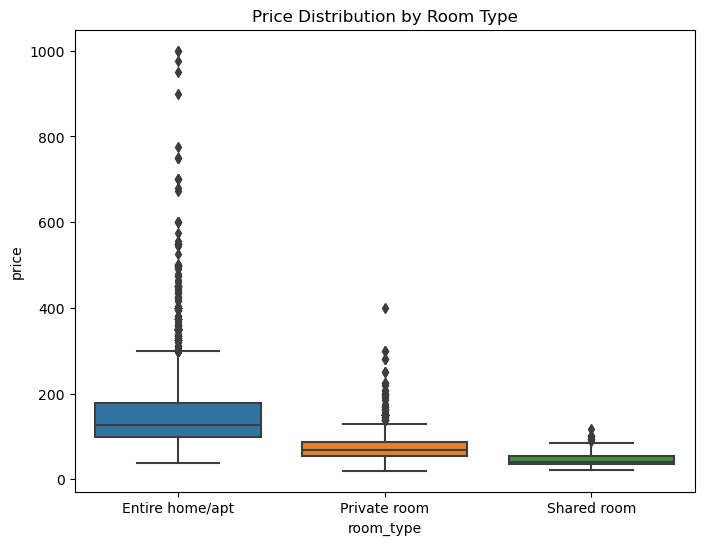

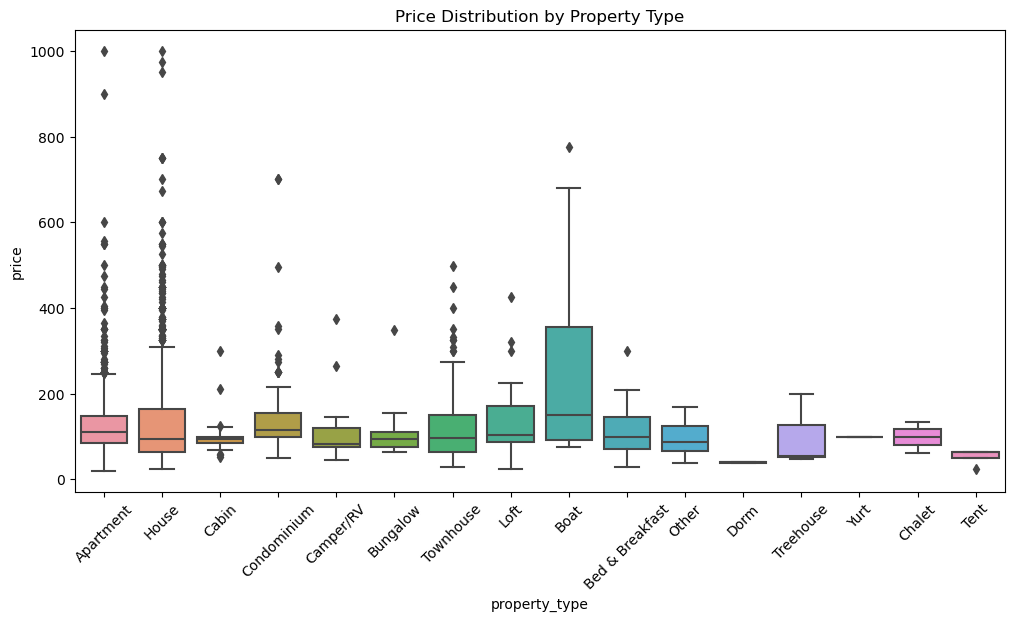

In [27]:
# Box plot of price by room type
plt.figure(figsize=(8, 6))
plot_data(listings_df1, 'room_type', 'price', 'Price Distribution by Room Type', plot_type='box')
# Box plot of price by property type
plt.figure(figsize=(12, 6))
plt.xticks(rotation=45) 
plot_data(listings_df1, 'property_type', 'price', 'Price Distribution by Property Type', plot_type='box')

**Figure 1 above shows that price distribution varies significantly depending on the room type, with entire home/apts generally commanding higher prices and exhibiting more variability compared to private rooms and shared rooms.**

**Figure 2 above shows  illustrates that boat have the highest prices, while dorm ,yurt and tents have the lowest. Other property types fall in between.** 

## Question 3: Can we predict the likelihood of a positive review based on listing attributes?

## Data Understanding

We will focus on the attributes 'accommodates', 'bedrooms', 'bathrooms', and 'price' to determine if they can predict the likelihood of a positive review, defined as having a review score rating of 90 or higher in the dataset listings_df2.




In [21]:
listings_df2 = listings_df.copy()

## Data Preparation

For the 'price' column we will remove the dollar sign and commas from the 'price' column, and convert the values to float data type.

Also, we have fill the otherg missing values with the meanto  preserves data distributio  and maintains compatibility with machine learning algorithms.

In [22]:
# Preprocess the 'price' column
listings_df2['price'] = listings_df2['price'].str.replace('$', '').str.replace(',', '').astype(float)

# Handle missing values if any
listings_df2['accommodates'].fillna(listings_df2['accommodates'].mean(), inplace=True)
listings_df2['bedrooms'].fillna(listings_df2['bedrooms'].mean(), inplace=True)
listings_df2['bathrooms'].fillna(listings_df2['bathrooms'].mean(), inplace=True)
listings_df2['price'].fillna(listings_df2['price'].mean(), inplace=True)

## Modeling

In the modeling phase,we willIselect thed relevant features and target variable, then split the data into training and testing sets before standardizing the features and training a logistic regression model to make predictions on the test set.

In [23]:
# Select relevant features and target variable
selected_features = ['accommodates', 'bedrooms', 'bathrooms', 'price']  # Add more features as needed
X = listings_df2[selected_features]
y = listings_df2['review_scores_rating'] >= 90  # Assuming positive review if review score is >= 90


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred = model.predict(X_test_scaled)

## Evaluation

In the evaluation phase, I assessed the model's performance by calculating its accuracy score and generating a classification report to examine precision, recall, and F1-score metrics for predicting positive reviews based on the selected features.

In [24]:
# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7460732984293194


In [25]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       194
        True       0.75      1.00      0.85       570

    accuracy                           0.75       764
   macro avg       0.37      0.50      0.43       764
weighted avg       0.56      0.75      0.64       764



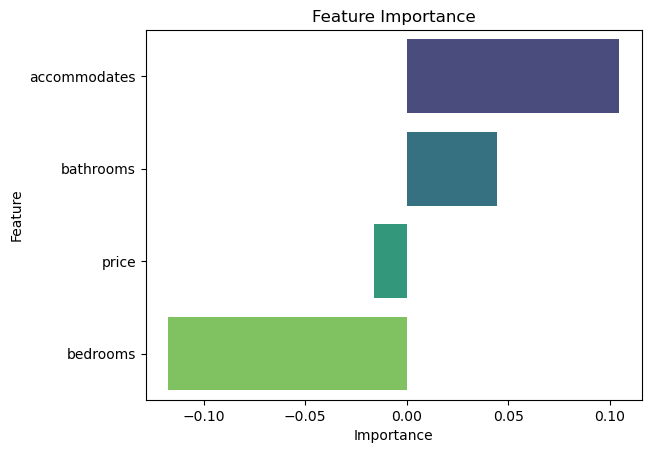

In [26]:
# Feature importance
if hasattr(model, 'coef_'):
    feature_importance = pd.DataFrame({'Feature': selected_features, 'Importance': model.coef_[0]})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plot_data(feature_importance, 'Importance', 'Feature', 'Feature Importance', plot_type='bar',  palette='viridis')


**Figure above shows that that while attributes like Accommodate and Bathrooms contribute positively to the likelihood of positive reviews, attributes like Bedrooms and Price may have a negative impact